In [1]:
from JEFF_Lib import (
    cov_skip_miss, corr_skip_miss, cov_pairwise, corr_pairwise, ewCovar, ewCorr,
    cov_with_different_ew_var_corr, near_psd, _getAplus, _getPS, _getPu, wgtNorm,
    higham_psd, chol_psd, simulate_normal, simulate_pca, FittedModel, fit_normal,
    fit_general_t, general_t_ll, fit_regression_t, return_calculate, VaR_cal, simple_VaR,
    simple_VaR_sim, simple_ES, simple_ES_sim, VaR_ES, Historical_VaR_ES
)

import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
from scipy.optimize import brentq
from scipy.stats import norm
from statsmodels.tsa.arima.model import ARIMA

# Problem 1

In [2]:
# Given data
underlying = 165
strike = 165
rf = 5.25 / 100
q = 0.53 / 100
b = rf - q

current_date = "2023-03-03"
expiration_date = "2023-03-17"
days = (np.datetime64(expiration_date) - np.datetime64(current_date)).astype(int)

tradingDayYear = 365
ttm = days / tradingDayYear
print(ttm)

0.038356164383561646


In [3]:
def gbsm(call, underlying, strike, ttm, rf, b, ivol):
    
    d1 = (np.log(underlying / strike) + (b + ivol**2 / 2) * ttm) / (ivol * np.sqrt(ttm))
    d2 = d1 - ivol * np.sqrt(ttm)
    
    if call:
        # Call option price
        return underlying * np.exp((b - rf) * ttm) * norm.cdf(d1) - strike * np.exp(-rf * ttm) * norm.cdf(d2)
    else:
        # Put option price
        return strike * np.exp(-rf * ttm) * norm.cdf(-d2) - underlying * np.exp((b - rf) * ttm) * norm.cdf(-d1)

In [4]:
# Range of implied volatilities from 10% to 80%
implied_vols = np.linspace(0.1, 0.8, 15)
 

# Calculate call and put option values for each implied volatility
call_values = []
put_values = []

for ivol in implied_vols:
    call_value = gbsm(True, underlying, strike, ttm, rf, b, ivol)
    put_value = gbsm(False, underlying, strike, ttm, rf, b, ivol)
    call_values.append(call_value)
    put_values.append(put_value)

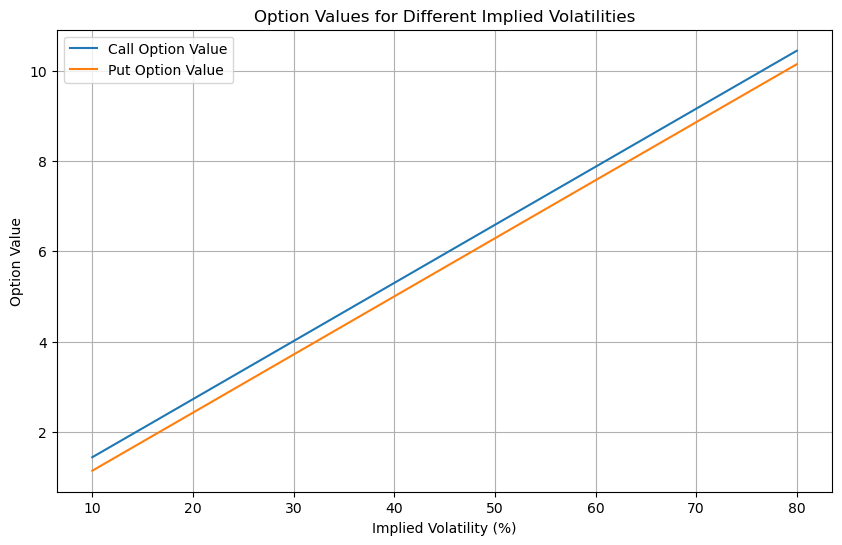

In [5]:
# Plot the results
plt.figure(figsize=(10, 6))
plt.plot(implied_vols * 100, call_values, label="Call Option Value")
plt.plot(implied_vols * 100, put_values, label="Put Option Value")
plt.xlabel("Implied Volatility (%)")
plt.ylabel("Option Value")
plt.title("Option Values for Different Implied Volatilities")
plt.legend()
plt.grid(True)
plt.show()

# Problem 2

In [6]:
# Load data
file_path = 'AAPL_Options.csv'
original_data = pd.read_csv(file_path)
data = original_data.copy()

In [7]:
# Given data
underlying = 170.15

rf = 5.25 / 100
q = 0.57 / 100
b = rf - q

current_date = "2023-10-30"
expiration_date = "2023-12-15"
days = (np.datetime64(expiration_date) - np.datetime64(current_date)).astype(int)

tradingDayYear = 365
ttm = days / tradingDayYear

In [8]:
# Function to calculate implied volatility
def calculate_implied_volatility(call, option_price, underlying, strike, ttm, rf, b):
    # Define the objective function to find the root
    objective = lambda ivol: gbsm(call, underlying, strike, ttm, rf, b, ivol) - option_price
    
    # Use Brent's method to find the implied volatility that makes the model price equal to the market price
    try:
        implied_vol = brentq(objective, 1e-5, 5)
        return implied_vol
    except ValueError:
        return np.nan  # Return NaN if the implied volatility is not found

In [9]:
# Apply the implied volatility calculation
implied_vols = []
for _, row in data.iterrows():
    call = row['Type'] == 'Call'
    implied_vol = calculate_implied_volatility(
        call, row['Last Price'], underlying, row['Strike'],
        ttm, rf, b
    )
    implied_vols.append(implied_vol)

data['Implied Volatility'] = implied_vols
data['Implied Volatility']

0          NaN
1     0.342728
2     0.374270
3     0.345630
4     0.314111
5     0.299383
6     0.275944
7     0.261183
8     0.246236
9     0.235327
10    0.229500
11    0.378369
12    0.360649
13    0.342034
14    0.323954
15    0.310123
16    0.294251
17    0.280079
18    0.270984
19    0.263976
20    0.244299
21    0.286510
Name: Implied Volatility, dtype: float64

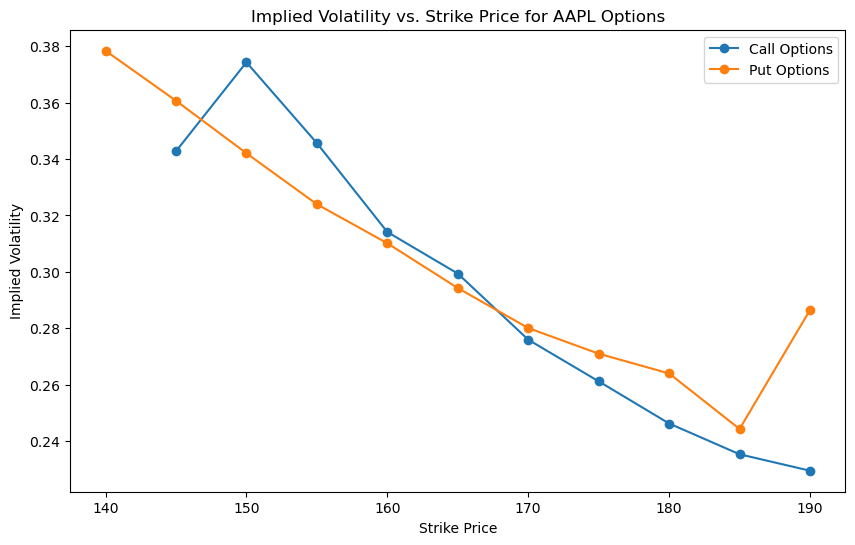

In [10]:
# Separate call and put data for plotting
calls = data[data['Type'] == 'Call']
puts = data[data['Type'] == 'Put']

# Plot implied volatility vs. strike price for calls and puts
plt.figure(figsize=(10, 6))
plt.plot(calls['Strike'], calls['Implied Volatility'], label='Call Options', marker='o')
plt.plot(puts['Strike'], puts['Implied Volatility'], label='Put Options', marker='o')
plt.xlabel('Strike Price')
plt.ylabel('Implied Volatility')
plt.title('Implied Volatility vs. Strike Price for AAPL Options')
plt.legend()
plt.show()

# Problem 3

In [11]:
# Given data
underlying = 170.15

rf = 5.25 / 100
q = 0.57 / 100
b = rf - q

current_date = "2023-10-30"
expiration_date = "2023-12-15"
days = (np.datetime64(expiration_date) - np.datetime64(current_date)).astype(int)

tradingDayYear = 365
ttm = days / tradingDayYear

In [12]:
# Load data
original_df_portfolio = pd.read_csv('problem3.csv')
df_portfolio = original_df_portfolio.copy()

# Define range of underlying prices
AAPL_prices = np.linspace(100, 200, 50)  
portfolio_values = {}

# Apply the implied volatility calculation
implied_vols = []
for _, row in df_portfolio.iterrows():
    if row['Type'] == 'Option':
        call = row['OptionType'] == 'Call'
        implied_vol = calculate_implied_volatility(
            call, row['CurrentPrice'], underlying, row['Strike'],
            ttm, rf, b
        )
    implied_vols.append(implied_vol)

df_portfolio['Implied Volatility'] = implied_vols
df_portfolio['Implied Volatility']

0     0.275944
1     0.280079
2     0.275944
3     0.280079
4     0.275944
5     0.246236
6     0.280079
7     0.310123
8     0.310123
9     0.275944
10    0.280079
11    0.280079
12    0.261183
13    0.261183
14    0.294251
Name: Implied Volatility, dtype: float64

In [13]:
for portfolio in df_portfolio['Portfolio'].unique():
    portfolio_data = df_portfolio[df_portfolio['Portfolio'] == portfolio]
    values = []
    for S in AAPL_prices:
        total_value = 0
        for _, row in portfolio_data.iterrows():
            if row['Type'] == 'Option':
                call = row['OptionType'] == 'Call'
                ivol = row['Implied Volatility']
                option_value = gbsm(call, S, row['Strike'], ttm, rf, b, ivol)
                total_value += row['Holding'] * option_value
            elif row['Type'] == 'Stock':
                stock_value = S * row['Holding']
                total_value += stock_value
        values.append(total_value)
    portfolio_values[portfolio] = values

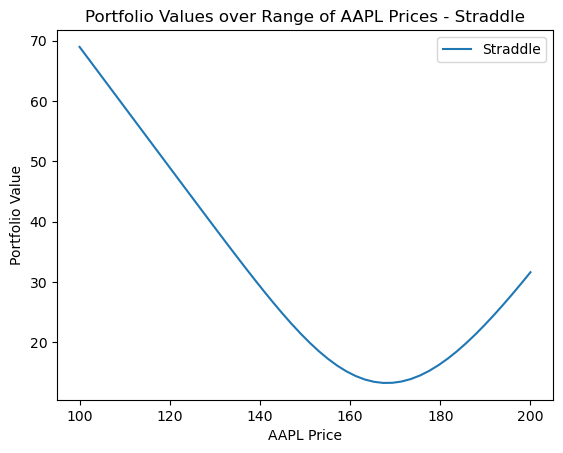

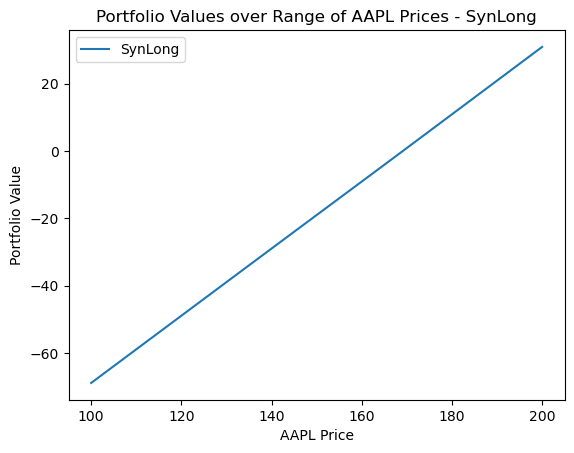

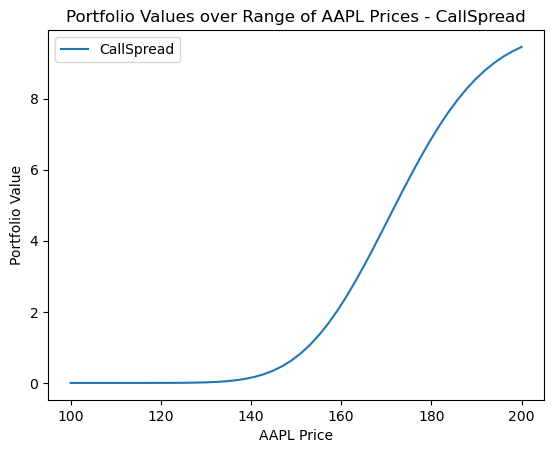

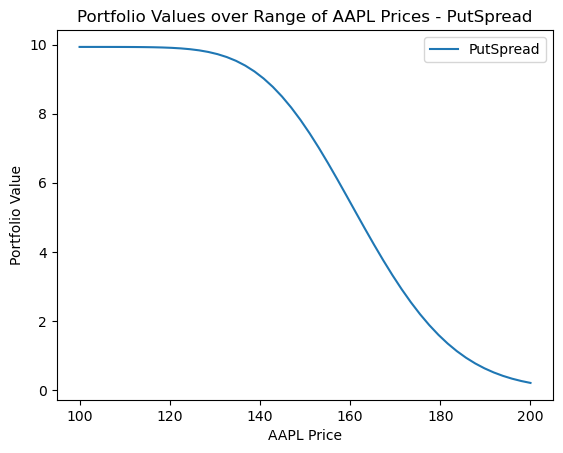

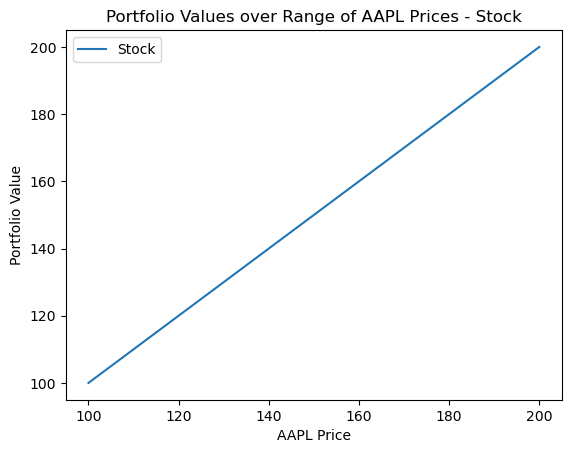

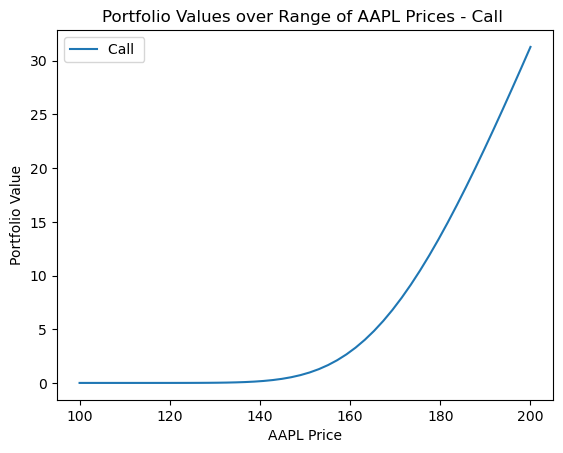

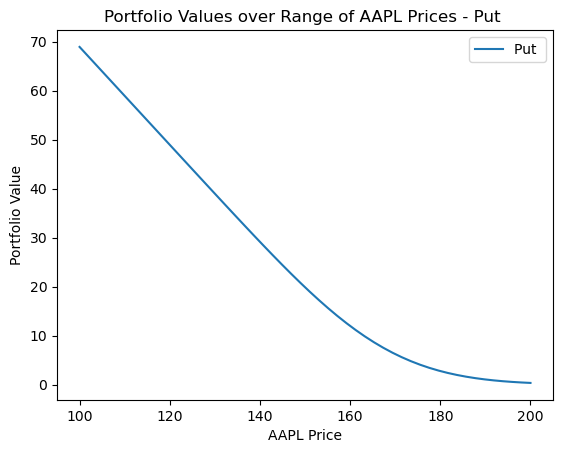

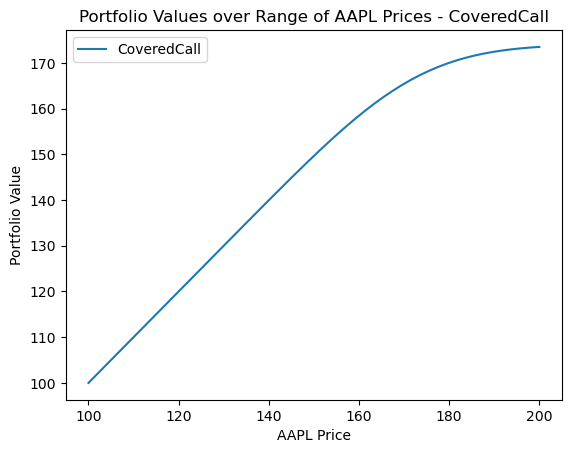

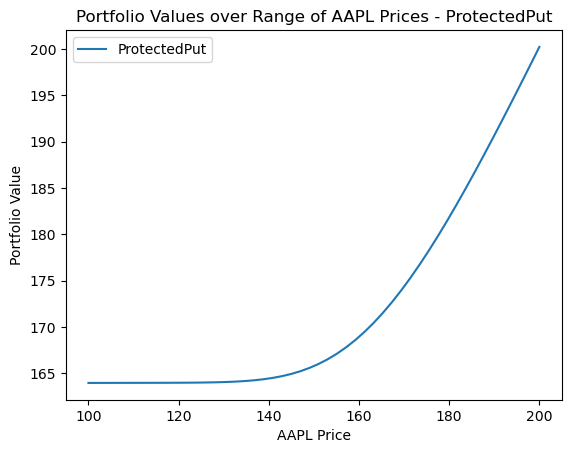

In [14]:
# Plot each portfolio's values separately
for portfolio, values in portfolio_values.items():
    plt.figure()  # Create a new figure for each portfolio
    plt.plot(AAPL_prices, values, label=portfolio)
    plt.xlabel('AAPL Price')
    plt.ylabel('Portfolio Value')
    plt.title(f'Portfolio Values over Range of AAPL Prices - {portfolio}')
    plt.legend()
    plt.show()

In [15]:
# Load daily AAPL data
original_df_prices = pd.read_csv('DailyPrices.csv')
df_prices = original_df_prices.copy()

returns = return_calculate(df_prices, method="LOG", date_column="Date")
returns

,SPY,AAPL,MSFT,AMZN,NVDA,GOOGL,TSLA,GOOG,BRK-B,META,...,ETN,SLB,PGR,SCHW,LRCX,ZTS,C,BSX,AMT,Date
0,-0.010600,-0.013705,-0.016807,-0.002428,-0.021027,-0.017373,-0.025396,-0.017060,-0.016997,-0.030953,...,-0.010650,0.032571,-0.010483,-0.019429,-0.004245,-0.015361,0.001844,-0.012273,-0.026708,2022-09-02
1,-0.003780,-0.008249,-0.011035,-0.011040,-0.013426,-0.009690,0.015460,-0.011103,-0.003897,-0.011165,...,0.008413,-0.014219,0.000572,0.001846,-0.008052,-0.000892,-0.012776,-0.002720,0.013187,2022-09-06
2,0.017806,0.009211,0.018931,0.026372,0.018621,0.024416,0.033258,0.027530,0.015961,0.011601,...,0.020091,-0.008062,0.037813,0.018558,0.012204,0.022445,0.008467,0.026636,0.020714,2022-09-07
3,0.006515,-0.009664,0.001665,0.002623,0.019926,-0.009824,0.019409,-0.009641,0.008151,0.010358,...,0.013849,0.029512,0.015756,0.018904,0.016438,-0.011979,0.025780,0.029463,0.008327,2022-09-08
4,0.015416,0.018664,0.022717,0.026228,0.027982,0.020729,0.035389,0.021339,0.008540,0.042819,...,0.017097,0.038041,-0.004188,0.018687,0.026116,0.036063,0.015313,0.005371,-0.000306,2022-09-09
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
260,0.000586,0.016772,-0.003519,-0.002925,0.001502,0.005878,-0.033765,0.004761,0.006962,0.007431,...,0.006914,0.010346,0.013033,-0.006203,0.019925,-0.003334,-0.001640,0.001889,-0.003392,2023-09-18
261,-0.002076,0.006162,-0.001247,-0.016931,-0.010196,-0.001231,0.004588,-0.000936,0.000135,0.008295,...,-0.013738,-0.012825,0.013497,-0.002249,-0.016656,0.012886,0.000938,0.000566,-0.012161,2023-09-19
262,-0.009236,-0.020195,-0.024269,-0.017148,-0.029877,-0.031646,-0.014780,-0.031017,-0.009928,-0.017859,...,-0.007010,-0.010647,0.001543,-0.018532,-0.010113,-0.002751,-0.008943,0.019976,0.000282,2023-09-20
263,-0.016666,-0.008929,-0.003873,-0.045053,-0.029357,-0.024984,-0.026589,-0.024291,-0.009697,-0.013235,...,-0.018811,-0.016357,-0.002035,-0.011715,-0.013781,-0.027088,-0.014046,-0.002406,-0.046673,2023-09-21


In [16]:
# Remove the mean from the series so that mean(AAPL) = 0
returns['AAPL'] -= returns['AAPL'].mean()

# Fit AR(1) model using ARIMA
model = ARIMA(returns['AAPL'], order=(1, 0, 0))
model_fit = model.fit()

# Extract AR(1) parameters
phi_0 = model_fit.params['const'] 
phi_1 = model_fit.params['ar.L1']  
residual_std = model_fit.resid.std()  

In [17]:
# Initialize variables for simulation
num_days = 10
simulated_returns = []
last_return = returns['AAPL'].iloc[-1] 

# Generate 10 days of simulated returns using the AR(1) model
for _ in range(num_days):
    next_return = phi_0 + phi_1 * last_return + np.random.normal(0, residual_std)
    simulated_returns.append(next_return)
    last_return = next_return

# Apply simulated returns to project the AAPL price for each of the 10 days
simulated_prices = [underlying]
for r in simulated_returns:
    next_price = simulated_prices[-1] * np.exp(r) 
    simulated_prices.append(next_price)

simulated_prices

[170.15,
 169.8588986835795,
 173.47467146178772,
 171.05521243296562,
 171.72736233752804,
 173.32665071242425,
 174.17115031118783,
 168.29603773377013,
 162.65263083282264,
 155.740175860194,
 154.79955436692686]

In [18]:
# Calculate Initial Portfolio Value for Each Portfolio
initial_portfolio_values = {}

for portfolio in df_portfolio['Portfolio'].unique():
    portfolio_data = df_portfolio[df_portfolio['Portfolio'] == portfolio]
    initial_value = 0
    for _, row in portfolio_data.iterrows():
        if row['Type'] == 'Option':
            call = row['OptionType'] == 'Call'
            ivol = row['Implied Volatility']
            option_value = gbsm(call, underlying, row['Strike'], ttm, rf, b, ivol)
            initial_value += row['Holding'] * option_value
        elif row['Type'] == 'Stock':
            initial_value += row['Holding'] * underlying
    initial_portfolio_values[portfolio] = initial_value

In [19]:
# Calculate P&L for each simulated day
portfolio_values = []
for day, price in enumerate(simulated_prices[1:], start=1): 
    portfolio_value = 0
    for _, row in df_portfolio.iterrows():
        ttm = (np.datetime64(expiration_date) - np.datetime64(current_date) - np.timedelta64(day, 'D')).astype(int) / 365
        if row['Type'] == 'Option' and ttm > 0:
            call = row['OptionType'] == 'Call'
            ivol = row['Implied Volatility']
            option_value = gbsm(call, price, row['Strike'], ttm, rf, b, ivol)
            portfolio_value += row['Holding'] * option_value
        elif row['Type'] == 'Stock':
            portfolio_value += row['Holding'] * price
    portfolio_values.append(portfolio_value)

In [20]:
# Calculate Daily Portfolio Value Over 10 Simulated Days and P&L
portfolio_PL = {portfolio: [] for portfolio in df_portfolio['Portfolio'].unique()}

for day, price in enumerate(simulated_prices[1:], start=1):  
    for portfolio in df_portfolio['Portfolio'].unique():
        portfolio_data = df_portfolio[df_portfolio['Portfolio'] == portfolio]
        daily_value = 0
        for _, row in portfolio_data.iterrows():
            ttm = (np.datetime64(expiration_date) - np.datetime64(current_date) - np.timedelta64(day, 'D')).astype(int) / 365
            if row['Type'] == 'Option' and ttm > 0:
                call = row['OptionType'] == 'Call'
                ivol = row['Implied Volatility']
                option_value = gbsm(call, price, row['Strike'], ttm, rf, b, ivol)
                daily_value += row['Holding'] * option_value
            elif row['Type'] == 'Stock':
                daily_value += row['Holding'] * price
        portfolio_PL[portfolio].append(daily_value - initial_portfolio_values[portfolio])

In [21]:
distribution = "Normal"

# Calculate Daily Returns for Each Portfolio
portfolio_returns = {portfolio: [] for portfolio in portfolio_PL.keys()}

for portfolio, pl_values in portfolio_PL.items():
    # Calculate daily returns from daily P&L values
    initial_value = initial_portfolio_values[portfolio]
    portfolio_returns[portfolio] = [(pl / initial_value) for pl in pl_values]

# Calculate Mean, VaR, and ES for Each Portfolio
portfolio_metrics = {}

for portfolio, returns in portfolio_returns.items():
    returns = np.array(returns)  # Convert to numpy array for compatibility

    # Calculate mean of returns
    mean_return = np.mean(returns)
    
    # Calculate VaR 
    var_value = simple_VaR(returns, distribution, alpha=0.05)[0]
    
    # Calculate ES using JEFF_Lib's simple_ES function
    es_value = simple_ES(returns, distribution, alpha=0.05)[0]
    
    # Store metrics for the portfolio
    portfolio_metrics[portfolio] = {
        'Mean': mean_return,
        'VaR': var_value,
        'ES': es_value
    }

# Convert portfolio metrics dictionary into a DataFrame
portfolio_metrics_df = pd.DataFrame.from_dict(portfolio_metrics, orient='index')
portfolio_metrics_df.index.name = 'Portfolio'
portfolio_metrics_df.reset_index(inplace=True)

# Display the DataFrame
print(portfolio_metrics_df)

      Portfolio      Mean        VaR         ES
0      Straddle  0.026828   0.152779   0.198406
1       SynLong -2.611656  14.028682  16.929067
2    CallSpread -0.151310   0.775118   0.933590
3     PutSpread  0.218425   0.685200   0.914758
4         Stock -0.015514   0.085666   0.103488
5         Call  -0.165295   0.868317   1.046914
6          Put   0.251699   0.885189   1.174004
7   CoveredCall -0.010950   0.061952   0.074909
8  ProtectedPut -0.008321   0.045542   0.054997
